# CatBoost

## Навигация

- [Оптимизация гиперпараметров с кросс-валидацией](#Оптимизация-гиперпараметров-с-кросс-валидацией)
- [Refit на всём X_train](#Refit-на-всём-X_train)
- [Perfomance на X_test](#Perfomance-на-X_test)
- [SHAP values](#SHAP-values)

In [1]:
import os
import sys
sys.path.append('..')
from typing import Dict

import catboost
import optuna
import pandas as pd
import shap
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer

from my_ds_tools.classification import my_multiclass_classification_report
import src

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
DATA_PATH = os.path.join('..', 'data', 'processed', 'encoded.csv')

N_TRIALS = 5
N_SPLITS = 10

CAT_FEATURES = sorted(list(src.constants.CATEGORICAL_FEATURES))
FEATURES_TO_IMPUT = [src.constants.QUESTION_2]
USEFUL_FOR_IMPUT = [
    src.constants.QUESTION_6, src.constants.QUESTION_8, src.constants.QUESTION_31,
    src.constants.QUESTION_32, src.constants.QUESTION_33, src.constants.QUESTION_34,
    src.constants.QUESTION_35,
]

In [4]:
data = pd.read_csv(DATA_PATH)

y = data[src.constants.TARGET]
X = data.drop(columns=src.constants.TARGET)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=src.constants.RANDOM_STATE)

## Оптимизация гиперпараметров с кросс-валидацией

[К навигации](#Навигация)

In [5]:
def objective(trial: optuna.trial.Trial) -> float:
    """Целевая функция для оптимизации гиперпараметров."""
    model = get_model(trial, mode='fit')
    scores = cross_val_score(
        estimator=model,
        X=X_train,
        y=y_train,
        scoring='accuracy',
        cv=StratifiedShuffleSplit(n_splits=N_SPLITS, random_state=src.constants.RANDOM_STATE),
        n_jobs=-1,
    )
    
    return scores.mean()


def get_model(trial: optuna.trial.Trial, mode: str) -> sklearn.pipeline.Pipeline:
    preprocessing = ColumnTransformer(
        transformers=[
            ('knn_imputer', KNNImputer(), FEATURES_TO_IMPUT + USEFUL_FOR_IMPUT),
            ('constant_imputer', SimpleImputer(strategy='constant', fill_value='пропуск'), CAT_FEATURES),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False,
    ).set_output(transform='pandas')

    catboost_model = catboost.CatBoostClassifier(**get_init_hyperparams(trial, mode))

    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('catboost', catboost_model),
    ])

    return pipe


def get_init_hyperparams(trial: optuna.trial.Trial, mode: str) -> Dict:
    match mode:
        case 'fit':
            max_depth = trial.suggest_int('max_depth', 1, 5)
        case 'refit':
            max_depth = trial.params['max_depth']
        case _:
            assert False, 'ABOBA'

    init_hyperparams = dict(
        max_depth=max_depth,
        cat_features=CAT_FEATURES,
        verbose=0,
        random_state=src.constants.RANDOM_STATE,
    )

    return init_hyperparams

In [6]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=src.constants.RANDOM_STATE),
    direction='maximize',
    study_name='catboost',
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
print('Лучшие гиперпараметры:')
for hyperparam, value in study.best_trial.params.items():
    print(f'* {hyperparam}: {value}')
print(f'Лучший mean Accuracy: {study.best_trial.value}')

Лучшие гиперпараметры:
* max_depth: 5
Лучший mean Accuracy: 0.6977777777777778


In [8]:
model = get_model(study.best_trial, mode='refit')
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knn_imputer', KNNImputer(),
                                                  ['2. Возраст',
                                                   '6. Жив ли хотя бы один из '
                                                   'Ваших родителей (да/нет)?',
                                                   '8. Есть ли у Вас дети '
                                                   '(да/нет)?',
                                                   '31. Количество родов',
                                                   '32. Количество прерванных '
                                                   'беременностей',
                                                   '33. Гинекологические '
                                                   'заболевания (да/нет)',
                                                   '34. Заболевания щитовидной '
                                                   'железы (да/нет)',
                                                   '35. Наследственность '
                                                   '(да/нет)']),
                                                 ('constant_imputer',
                                                  SimpleImputer(fill_value='пропуск',
                                                                strategy='constant'),
                                                  ['23. Каков тип Вашего дома?',
                                                   '25. Каким транспортом Вы '
                                                   'обычно пользуетесь?',
                                                   '3. Семейное положение'])],
                                   verbose_feature_names_out=False)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x000002440C1DA610>)])

## Refit на всём X_train

[К навигации](#Навигация)

In [9]:
model = get_model(study.best_trial, mode='refit')
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knn_imputer', KNNImputer(),
                                                  ['2. Возраст',
                                                   '6. Жив ли хотя бы один из '
                                                   'Ваших родителей (да/нет)?',
                                                   '8. Есть ли у Вас дети '
                                                   '(да/нет)?',
                                                   '31. Количество родов',
                                                   '32. Количество прерванных '
                                                   'беременностей',
                                                   '33. Гинекологические '
                                                   'заболевания (да/нет)',
                                                   '34. Заболевания щитовидной '
                                                   'железы (да/нет)',
                                                   '35. Наследственность '
                                                   '(да/нет)']),
                                                 ('constant_imputer',
                                                  SimpleImputer(fill_value='пропуск',
                                                                strategy='constant'),
                                                  ['23. Каков тип Вашего дома?',
                                                   '25. Каким транспортом Вы '
                                                   'обычно пользуетесь?',
                                                   '3. Семейное положение'])],
                                   verbose_feature_names_out=False)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x000002440C1C5D10>)])

## Perfomance на X_test

[К навигации](#Навигация)

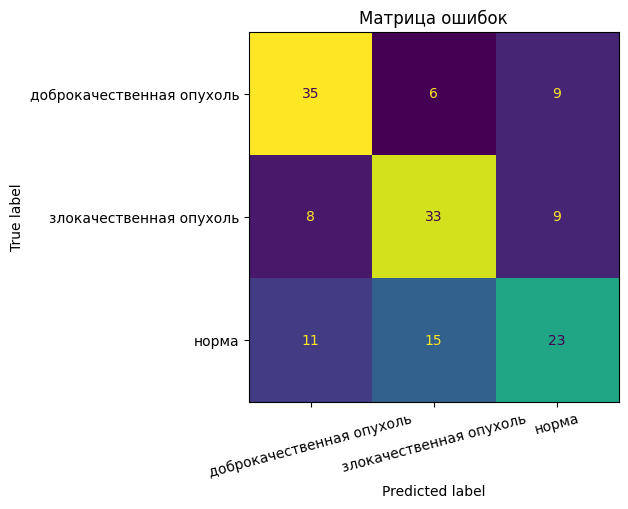

                           precision    recall  f1-score   support

доброкачественная опухоль       0.65      0.70      0.67        50
  злокачественная опухоль       0.61      0.66      0.63        50
                    норма       0.56      0.47      0.51        49

                 accuracy                           0.61       149
                macro avg       0.61      0.61      0.61       149
             weighted avg       0.61      0.61      0.61       149



In [10]:
my_multiclass_classification_report(model, X_test, y_test, cm_kw=dict(xticks_rotation=15))

## SHAP values

[К навигации](#Навигация)

In [13]:
catboost_model = model.named_steps['catboost']
preprocessing = model.named_steps['preprocessing']

In [14]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(preprocessing.transform(X))

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


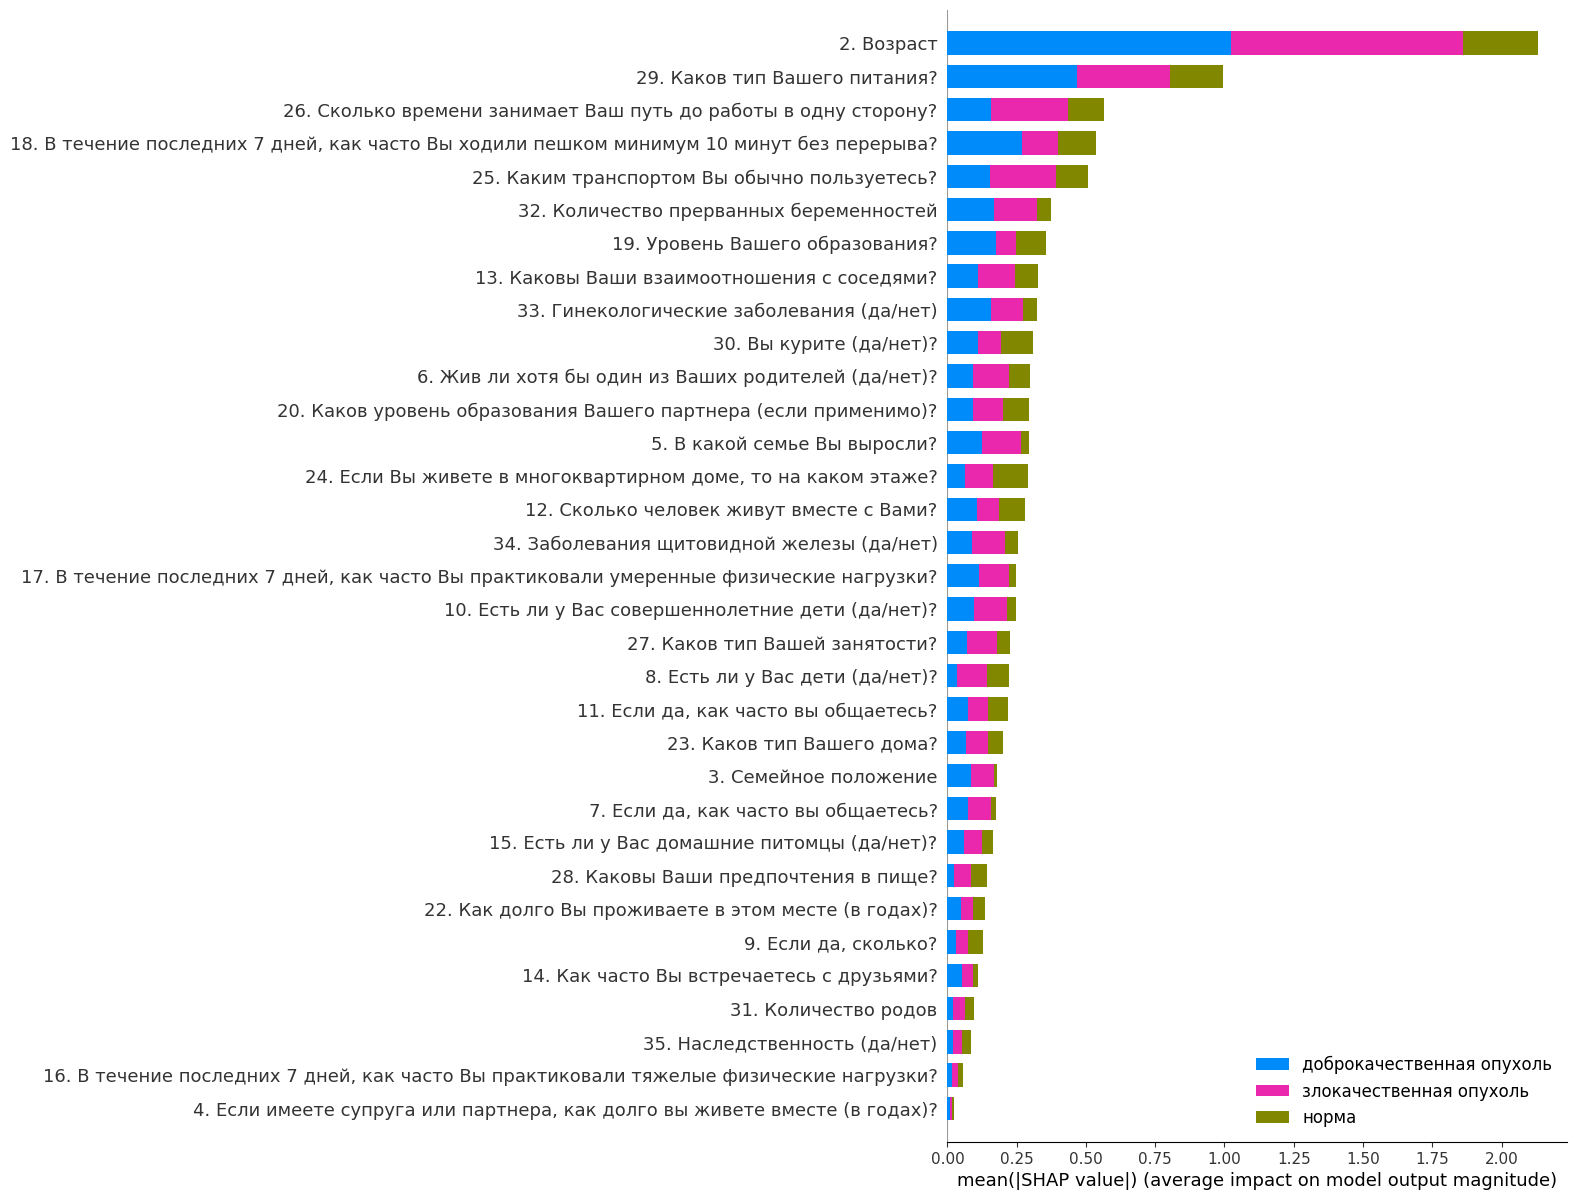

In [30]:
shap.summary_plot(
    shap_values=shap_values,
    features=X,
    class_names=['доброкачественная опухоль', 'злокачественная опухоль', 'норма'],
    max_display=33,
)